# Web Scraping Indeed for Key Data Science Job Skills: 
## Edited: the parser lxml-xml in addition to html5parser
Note: this was originally by Swami Chandrasekaran. I only edited a few lines.

As many of you probably know, being a data scientist can require a pretty large skill set . . .

Credit: [Swami Chandrasekaran](http://nirvacana.com/thoughts/becoming-a-data-scientist/)

To master all of that at a high level would probably take a lifetime! I'm sure many data scientists would love to be highly skilled in all of these areas if possible, but busy Ph.D. students like me (that are trying to graduate in an efficient manner!) don't have enough time to focus on all of these skills.

So which of these skills are most employers actually looking for? 

On DataScienceCentral, I saw a link to [this posting](http://kumaranpm.blogspot.com/2014/11/popular-software-skills-in-data-science.html) by Kumaran Ponnambalam where he examined this question with R by scraping job postings. I thought it was an interesting idea. I wanted to find out this information for myself, as updated as possible, so I could see any changing trends in the job market. 

It would also be nice to see if different cities have different skills they like to emphasize (i.e. does the Silicon Valley market have different skills they prefer compared to New York City?)

Data like this isn't going to be easily accessible through a .csv or database. Sometimes, you are going to have to get it yourself. That may require [web scraping](http://en.wikipedia.org/wiki/Web_scraping), which automates the process of collecting data from websites. I've always thought this sounded very cool, but I didn't know how to do it. 

Luckily, Greg Reda at Datascope Analytics had a great blog post about web scraping that helped me complete this project (see it [here](http://www.gregreda.com/2013/03/03/web-scraping-101-with-python/)). He did a great job! I'm not going to go into as much detail about web scraping as he did in this notebook, so I would recommend going to his blog post if you want to learn the basics.

So, in this notebook, I am going to scrape job postings from Indeed.com for data science jobs and see which skills employers want the most (Python or R? Are they interested in Spark yet? How dominant are NoSQL databases? Are they using proprietary software like SAS or are companies preferring open source now?) To make it even better, I will create the program so that I can have a detailed breakdown by city. 

##Program Setup

The basic workflow of the program will be:

- Enter the city we want to search for jobs in matching the title "data scientist" (in quotes so it is a direct match) on Indeed.com
- See the list of job postings displayed by the website
- Access the link to each job posting
- Scrape all of the html in the job posting
- Filter it to only include words
- Reduce the words to a set so that each word is only counted once
- Keep a running total of the words and see how often a job posting included them

We will create two functions. The first will scape an individual job posting for the HTML, clean it up to get the words only, then output the final list of words. The second will manage which URLs to access via the job postings Indeed's website links to. 

In this notebook, we will use the urllib2 library to connect to the websites, the BeautifulSoup library to collect all of the HTML, the re library for parsing the words and filtering out other markup based on regular expressions, and pandas to manage and plot the final results. 

## The First Function: Cleaning a Website

This function will be called every time we access a new job posting. Its input is a URL for a website, while the output will be a final set of words collected from that website. 

In this notebook, I am going to import all of the libraries necessary first. 

In [9]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib2 # Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
import nltk
%matplotlib inline


In [15]:
try:
    site = urllib2.urlopen('http://www.indeed.com/viewjob?jk=41ad90bfca87914b&q=data+scientist&l=Denton%2C+TX&tk=1alqir6tka4ujc').read()
except urllib2.HTTPError,e:
    print e.code
    
soup_obj = BeautifulSoup(site, "lxml") # Get the html from the site
#print soup_obj    
if len(soup_obj) == 0: # In case the default parser lxml doesn't work, try another one
    soup_obj = BeautifulSoup(site, 'lxml-xml')
if len(soup_obj) == 0
    soup_obj = BeautifulSoup(site, 'html5lib')
print soup_obj    

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html lang="en">
<head><title>Data Analyst Market - Research Analyst job - Steele Careers - Grapevine, TX | Indeed.com</title>
<meta content="June 10, 2016 - Data Analyst Market - Research Analyst - Data Analyst Market - Research Analyst  br  Are you: Looking to use your excellent computer, SAP, and statistical experience in a global, billion" name="description"/>
<meta content="Data Analyst Market - Research Analyst job - Steele Careers - Grapevine, TX" name="keywords"/>
<link href="/job/Data-Analyst-Market-at-Steele-Careers-in-Grapevine,-TX-41ad90bfca87914b" rel="canonical"><meta content="NOINDEX" name="robots"><link href="/m/viewjob?jk=41ad90bfca87914b" media="handheld" rel="alternate">
<meta content="115882278440564" property="fb:app_id">
<meta content="Data Analyst Market - Research Analyst job - Steele Careers - Grapevine, TX" property="og:title">
<meta content="Indeed.com" property="og:site_name">
<meta content="http://www.i

Now create our first website parsing function.

In [16]:
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        site = urllib2.urlopen(website).read() # Connect to the job posting
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 
    
    soup_obj = BeautifulSoup(site, "lxml") # Get the html from the site
    
    if len(soup_obj) == 0: # In case the default parser lxml doesn't work, try another one
        soup_obj = BeautifulSoup(site, 'lxml-xml')
    if len(soup_obj) == 0: # In case the default parser lxml doesn't work, try another one
        soup_obj = BeautifulSoup(site, 'html5lib')
    
    
    
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    
    

    text = soup_obj.get_text() # Get the text from this

    

    lines = (line.strip() for line in text.splitlines()) # break into lines

    
    
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    

    text = ''.join(chunk for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line
    
    # Now clean out all of the unicode junk (this line works great!!!)
    
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception
   
    
    text = re.sub("[^a-zA-Z+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                             # Also include + for C++
    text = re.sub(r"([a-z])([A-Z])", r"\1 \2", text) # Fix spacing issue from merged words
    
    text = text.lower().split()  # Go to lower case and split them apart
    
    
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w for w in text if not w in stop_words]
    
    
    
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                           # or not on the website)
    
    return text

As you can see in the code above, a lot of cleaning for the raw html is necessary to get the final terms we are looking for. It extracts the relevant portions of the html, gets the text, removes blank lines and line endings, removes unicode, and filters with regular expressions to include only words. To see what the final result looks like, let's try calling this function on a sample job posting. The one I am using is a job posting for a [Data Scientist at Indeed itself](http://www.indeed.com/viewjob?jk=5505e59f8e5a32a4&q=%22data+scientist%22&tk=19ftfgsmj19ti0l3&from=web&advn=1855944161169178&sjdu=QwrRXKrqZ3CNX5W-O9jEvWC1RT2wMYkGnZrqGdrncbKqQ7uwTLXzT1_ME9WQ4M-7om7mrHAlvyJT8cA_14IV5w&pub=pub-indeed)!

If you are reading the notebook interactively, the example job posting may have disappeared so you can try your own to see how the function works. 

In [4]:
sample = text_cleaner('http://www.indeed.com/viewjob?jk=41ad90bfca87914b&q=data+scientist&l=Denton%2C+TX&tk=1alqir6tka4ujc4i&from=web')
sample[:20] # Just show the first 20 words

['consider',
 'office',
 'indeed',
 'accurate',
 'global',
 'dollar',
 'competitive',
 'trade',
 'bring',
 'manager',
 'including',
 'statistical',
 'innovative',
 'keywords',
 'paul',
 'find',
 'staff',
 'equipment',
 'position',
 'fit']

Now that we can extract terms from the website with our text_cleaner function, let's build another function that will call this and automatically loop through all of the websites on Indeed for us.

##The Second Function: Accessing the Job Postings

This next function will allow us to search for "data scientist" jobs in a particular city (or nationally if we want to see everything!) and plot the final results in a bar chart so we can see which skills are most frequently desired. 

This second function is fairly long, so I will try to explain how everything works through a lot of commentary. The basic idea is to look through Indeed's pages of job results and click on all of the job links, but only in the center of the page where all of the jobs are posted (not on the edges). See an example [here](http://www.indeed.com/jobs?q=%22data+scientist%22&l=). I just want the URLs in the "center" column of the website. You can get an idea of how Indeed organized the website by using a browser like Firefox or Chrome. Right click on the page to see the "Inspect Element" option in Firefox and the HTML will now be visible to you.

In [5]:
def skills_info(city = None, state = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
    
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
    
    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                   '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string


    base_url = 'http://www.indeed.com'


    try:
        html = urllib2.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html) # Get the html from the first page

    # Now find out how many jobs there were

    num_jobs_area = soup.find(id = 'searchCount').string.encode('utf-8') # Now extract the total number of jobs found
                                                                         # The 'searchCount' object has this

    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result


    if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers[2]) 

    city_title = city
    if city is None:
        city_title = 'Nationwide'
    
    print 'There were', total_num_jobs, 'jobs found,', city_title # Display how many jobs were found

    num_pages = total_num_jobs/10 # This will be how we know the number of times we need to iterate over each new
                                  # search result page
    job_descriptions = [] # Store all our descriptions in this list

    for i in xrange(1,num_pages+1): # Loop through all of our search result pages
        print 'Getting page', i
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
        
        html_page = urllib2.urlopen(current_page).read() # Get the page
        
        page_obj = BeautifulSoup(html_page) # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
        
        job_URLS = [base_url + link.get('href') for link in job_link_area.find_all('a')] # Get the URLS for the jobs
        
        job_URLS = filter(lambda x:'clk' in x, job_URLS) # Now get just the job related URLS
        
    
        for j in xrange(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
    
    print 'Done with collecting the job postings!'    
    print 'There were', len(job_descriptions), 'jobs successfully found.'


    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp

    # Now we can just look at our final dict list inside doc_frequency

    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for

    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                   'Ruby':doc_frequency['ruby'],
                  'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                  'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                  
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                      'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                      'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
               'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
               'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
               'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
               'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
               
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                 'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                 'MongoDB':doc_frequency['mongodb']})
                 
           
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects

    

    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 

    # Change the values to reflect a percentage of the postings 

    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                  #  having that term 

    # Sort the data for plotting purposes

    final_frame.sort(columns = 'NumPostings', ascending = False, inplace = True)

    # Get it ready for a bar plot
    
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                              title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
    
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
    
    
    return fig, final_frame # End of the function

Let's now try running our new function on Seattle, Washington to see what results we get. Just as a note, all of these results were run on March 8, 2015 (with the exception of the national results that were run the next day). 

C:\Users\Yu\Anaconda2\lib\site-packages\bs4\__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


There were 202 jobs found, Seattle
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Done with collecting the job postings!
There were 117 jobs successfully found.


C:\Users\Yu\Anaconda2\lib\site-packages\ipykernel\__main__.py:132: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


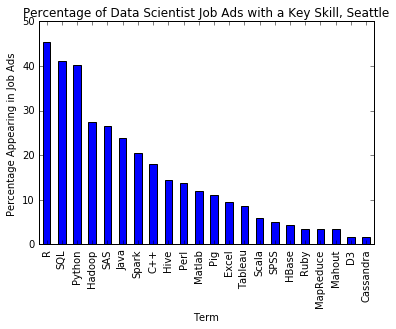

In [10]:
seattle_info = skills_info(city = 'Seattle', state = 'WA') 

Looking at the plot above, it seems Python is definitely the most commonly requested skill. Relational databases are used far more commonly than unstructured NoSQL databases. Spark doesn't seem to have caught on to very many jobs yet (only about 7%) but it is listed more frequently than Pig, which has been around much longer! It also seems R is starting to lose the infamous Python vs. R battle that data scientists like arguing about (in my opinion just use both for their strengths!) 

What if we tried a different job market, such as Chicago? How do things change here?

There were 150 jobs found, Chicago
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Done with collecting the job postings!
There were 94 jobs successfully found.


C:\Users\Yu\Anaconda2\lib\site-packages\ipykernel\__main__.py:132: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


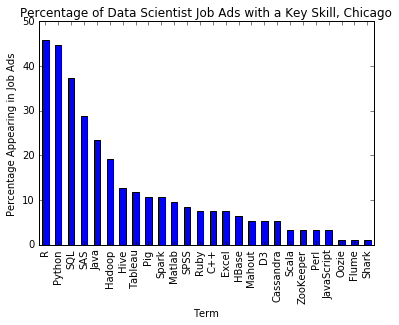

In [11]:
chicago_info = skills_info(city = 'Chicago', state = 'IL')

In the case of Chicago, it seems Hadoop is the top skill to have. My guess is some of the companies list Hadoop without really understanding that Hadoop is an entire framework and not a specific "skill." Python has now dropped to third place compared to Seattle. It also seems Spark appears in a greater percentage of job ads from Chicago than it did in Seattle, but Pig is requested more often. 

What about the largest Data Scientist job markets like San Francisco and New York City?

There were 345 jobs found, San Francisco
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Done with collecting the job postings!
There were 253 jobs successfully found.


C:\Users\Yu\Anaconda2\lib\site-packages\ipykernel\__main__.py:132: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


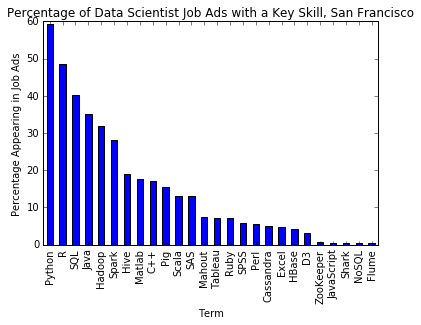

In [17]:
silicon_val_info = skills_info(city = 'San Francisco', state = 'CA')

Once again, Python is the top skill demanded, with R in second. In terms of the Hadoop framework, Hive was the most in demand. This makes sense given most companies are still dealing with structured data and Hive's strong similarity to SQL. Spark also beat Excel (thank goodness!) yet the percentage of job descriptions mentioning Spark was smaller in the Bay Area than in Chicago. A bit surprising since Spark originated at Berkeley, but this is just a snapshot in time after all. 

There were 347 jobs found, New York
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Getting page 27
Getting page 28
Getting page 29
Getting page 30
Getting page 31
Getting page 32
Getting page 33
Getting page 34
Done with collecting the job postings!
There were 260 jobs successfully found.


C:\Users\Yu\Anaconda2\lib\site-packages\ipykernel\__main__.py:132: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


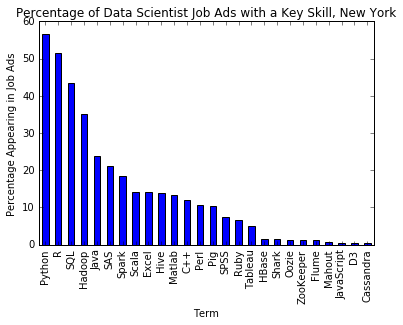

In [18]:
nyc_info = skills_info(city = 'New York', state = 'NY')

New York City and San Francisco had almost exactly the same number of job postings, which seems to show the job market is relatively balanced between the two coasts. R **finally** comes in first place in the Big Apple, with Python close behind. Demand for Spark seems pretty limited still, however. I think Spark has a bright future, so this may change by the end of the year. 

Last, let's see the overall national trend. (I ran this separately because it takes a long time to run). 

In [22]:
nyc_info = skills_info()

There were 3003 jobs found, Nationwide
Getting page 1


KeyboardInterrupt: 

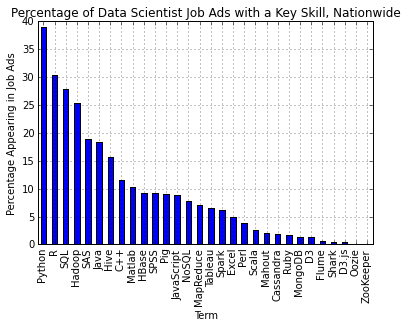

In [5]:
national_info[0]

From a national standpoint, I notice a few interesting things:

- Python is more in demand than R now for data science jobs. I think this will continue to be the trend as the Python data science community is further developed. Python is the "glue" that can hold almost every aspect of data science together. From data manipulation in pandas, machine learning with scikit-learn, web applications with Flash/Django, and an interface to Spark via PySpark, Python probably has you covered somewhere along the way. Is it always the best tool for the job? No, but it can usually get you there. R is still important in some areas where Python isn't quite as good yet (such as plotting or statistical libraries). With Microsoft [buying Revolution Analytics recently as an example](http://blog.revolutionanalytics.com/2015/01/revolution-acquired.html), R still has a role to play which is why it is in second place. 

- Data visualization doesn't seem to be in very high demand yet. D3 (or D3.js depending on the terminology the company used) is very low on the list. This surprised me because D3 seems to have [a lot of power](https://github.com/mbostock/d3/wiki/Gallery), yet it doesn't seem to have won many companies over as a skill they value. Tableau is still more popular, even though it isn't open source. 

- Even nationally, Spark is now (at least for this snapshot in time) a more in-demand skill than Excel. Perhaps companies are starting to realize that Excel isn't exactly the best tool for data science at scale (sorry Microsoft!) and is better suited for a Data Analyst role. 

##Summary

Designing our own web crawler, we were able to find out which skills companies are most interested in for data science jobs on Indeed. Trends vary somewhat between cities, but the top four skills were Python, R, SQL, and Hadoop pretty consistently. Java, SAS, and Hive would probably be considered the second tier.

Notice, however, that these skills are just for the software/programming languages that a data scientist should know. There are many others, such as machine learning, statistics, mathematics, and an understanding of what insights or products can be helpful to a business. These are also very important skills that are necessary to be a successful data scientist in my opinion, so don't forget about them!